https://www.analyticsvidhya.com/blog/2021/06/k-means-clustering-and-transfer-learning-for-image-classification/

https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from scipy.stats import mode

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import  KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from time import time
import os
import pathlib
import shutil
from skimage import io
import cv2

In [2]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import util

In [3]:
# Loading the complete dataset (including class 0)
df = pd.read_csv('data/train_complete.csv')
df.head()

,FilePath,ImageId,ClassId,EncodedPixels,Defect
0,/Users/fabioteichmann/neuefische/projects/Caps...,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,/Users/fabioteichmann/neuefische/projects/Caps...,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,/Users/fabioteichmann/neuefische/projects/Caps...,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,/Users/fabioteichmann/neuefische/projects/Caps...,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,/Users/fabioteichmann/neuefische/projects/Caps...,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1


In [4]:
# Loading the train dataset without class 0
df2 = pd.read_csv('data/train.csv')
df2.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
util.isolate_single_defects(df2)

In [6]:
df2.sample(10)

,ImageId,ClassId,EncodedPixels
4116,95a8e91c4.jpg,3,207657 2 207911 5 208164 8 208418 11 208672 14...
2876,6a06e0328.jpg,3,187685 220 187941 220 188197 220 188453 220 18...
2406,59bcf1693.jpg,3,138318 13 138570 28 138824 30 139080 30 139336...
3484,7f4bbb940.jpg,1,192204 11 192460 15 192715 21 192971 26 193226...
6344,e482bf630.jpg,3,305376 1 305579 4 305631 3 305833 5 305885 6 3...
6589,ed3276a76.jpg,1,36184 4 36432 12 36680 20 36928 28 37180 33 37...
2066,4c8759dd0.jpg,3,100106 33 100362 39 100617 45 100873 51 101128...
5726,cdd6cac95.jpg,3,64 28 320 28 576 28 832 28 1088 28 1344 28 160...
2096,4db535653.jpg,1,177705 2 177771 6 177959 6 178021 14 178214 9 ...
3224,75878cb48.jpg,3,181 72 437 72 694 71 950 71 1207 70 1463 70 16...


In [7]:
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(df)

In [8]:
# eliminate class 0 images in dataset
df = df.query('ClassId!=0')
df.shape

(6239, 5)

In [9]:
# safe all images with single defects
path = pathlib.Path.cwd()
try:
    os.mkdir(path.joinpath('data','single_defect_train_images'))
except:
    print('Folder already exists.')
    # von Michael kopiert für Ordnererstellung basierend auf x_train
for i in range(len(df)):
    origin_train_path = path.joinpath('data', 'train_images')
    source_file = df.iloc[i,1]
    target_directory = path.joinpath('data', 'single_defect_train_images')
    shutil.copy2(origin_train_path.joinpath(source_file) , target_directory.joinpath(source_file))


Folder already exists.


In [10]:
df.head()

,FilePath,ImageId,ClassId,EncodedPixels,Defect
0,/Users/fabioteichmann/neuefische/projects/Caps...,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,/Users/fabioteichmann/neuefische/projects/Caps...,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,/Users/fabioteichmann/neuefische/projects/Caps...,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,/Users/fabioteichmann/neuefische/projects/Caps...,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,/Users/fabioteichmann/neuefische/projects/Caps...,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1


### Preprozessing for single image (Example)

In [11]:
# load image (example)
images = io.imread('data/single_defect_train_images/0002cc93b.jpg')
print('Org image shape --> ',images.shape)

Org image shape -->  (256, 1600, 3)


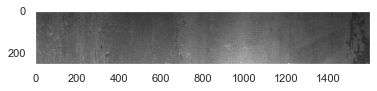

In [12]:
plt.rcParams['axes.grid'] = False
plt.imshow(images)

In [13]:
#resize images
IMG_SIZE = 32
image_resized=cv2.resize(images,(IMG_SIZE,IMG_SIZE))
print('After resizing shape --> ',image_resized.shape)

After resizing shape -->  (32, 32, 3)


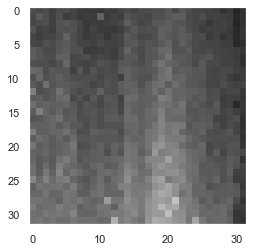

In [14]:
plt.rcParams['axes.grid'] = False
plt.imshow(image_resized)

In [15]:
#The input data have to be converted from 3 dimensional format to 1 dimensional format to be fed into the K-Means Clustering algorithm (Reshape images)
#image_flat = image_resized.reshape(len(image_resized),-1)
image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)

print('After Flattening shape --> ',image_flat.shape)

After Flattening shape -->  (1, 3072)


In [16]:
def get_prepared_images(df, image_size):
    
    image_ids = df.ImageId.to_list()
    image_list =[]
    prepared_images = pd.DataFrame()
    
    print('beginning to prepare images...')

    for image_id in image_ids:

        image = io.imread('data/augmentations/' + image_id)
        #resize images
        image_resized=cv2.resize(image, (image_size,image_size))
        #The input data have to be converted from 3 dimensional format to 1 dimensional format
        image_flat = image_resized.reshape(1, 3 * image_size * image_size)
        # Data Normalization
        # Conversion to float
        image_flat=image_flat.astype('float32')
        # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
        image_flat = image_flat / 255.0
        
        temp = pd.DataFrame(image_flat)
        prepared_images = pd.concat([prepared_images, temp], axis=0)
        
        if len(prepared_images) % 100 == 0 and len(prepared_images) != 0:
            print(f'{len(prepared_images)} images processed...')
        
        # image_list.append([image_id, image_flat[0]])
    prepared_images.reset_index(drop=True, inplace=True)
    print('adding Ids to the images...')
    prepared_images = pd.concat([df.ImageId, prepared_images], axis=1)
    # split_flattened_images = split_flat_images(temp) pd.DataFrame(df_flat_img['flattened_images'].tolist())
    print('done!')
    return prepared_images

In [17]:
flattened_images =[]

IMG_SIZE = 128
for image_id in df['ImageId']:
    image = io.imread('data/single_defect_train_images/' + image_id)
    #resize images
    image_resized=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    #The input data have to be converted from 3 dimensional format to 1 dimensional format
    image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)
    # Data Normalization
    # Conversion to float
    image_flat=image_flat.astype('float32')
    # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
    image_flat = image_flat/255.0
    flattened_images.append([image_id,image_flat[0]])

In [18]:
df_flat_img = pd.DataFrame(flattened_images , columns = ['ImageId', 'flattened_images'])
df_flat_img = pd.merge(df_flat_img, df[['ImageId','ClassId']], on='ImageId')


df_flat_img.head(2)

,ImageId,flattened_images,ClassId
0,0002cc93b.jpg,"[0.28627452, 0.28627452, 0.28627452, 0.2588235...",1
1,0007a71bf.jpg,"[0.19607843, 0.19607843, 0.19607843, 0.1882353...",3


In [19]:
#flattened_images.head(2)

In [20]:
split_flattened_images = pd.DataFrame(df_flat_img['flattened_images'].tolist())

In [25]:
split_flattened_images.head()

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,0.266667,0.239216,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.200000,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176
2,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.196078,0.196078,0.196078,0.200000,...,0.301961,0.309804,0.309804,0.309804,0.305882,0.305882,0.305882,0.298039,0.298039,0.298039
3,0.192157,0.192157,0.192157,0.309804,0.309804,0.309804,0.156863,0.156863,0.156863,0.227451,...,0.262745,0.156863,0.156863,0.156863,0.231373,0.231373,0.231373,0.196078,0.196078,0.196078
4,0.290196,0.290196,0.290196,0.286275,0.286275,0.286275,0.294118,0.294118,0.294118,0.286275,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922


In [21]:
df_flat_complete = pd.concat([df_flat_img, split_flattened_images], axis=1)
#flattened_images

In [22]:
df_flat_complete.head(2)

,ImageId,flattened_images,ClassId,0,1,2,3,4,5,6,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0002cc93b.jpg,"[0.28627452, 0.28627452, 0.28627452, 0.2588235...",1,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0007a71bf.jpg,"[0.19607843, 0.19607843, 0.19607843, 0.1882353...",3,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176


In [23]:
df_flat_complete.drop(['flattened_images'], axis=1, inplace=True)

In [24]:
df_flat_complete.head(2)

,ImageId,ClassId,0,1,2,3,4,5,6,7,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0002cc93b.jpg,1,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0007a71bf.jpg,3,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176


In [26]:
flattened_images_X = split_flattened_images

In [27]:
flattened_images_X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,0.266667,0.239216,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.200000,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176


In [ ]:
# # Use TSNE before modeling
# tsne = TSNE(n_components=2, init='random', random_state=0)
# digits_proj = tsne.fit_transform(flattened_images_X)
# # Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)
# kmeans = KMeans(n_clusters=4, random_state=0)
# clusters = kmeans.fit_predict(digits_proj)
# kmeans.cluster_centers_.shape

---

### Create Clusters (K-Means)

In [28]:
# without TSNE
# Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)
n_clusters=12
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(flattened_images_X)
kmeans.cluster_centers_.shape

(12, 49152)

In [29]:
clusters.shape

(6239,)

In [30]:
def plot_cluster_centers(n_clusters, kmeans):
    # Plot the cluster centers
    fig, ax = plt.subplots(4, 3, figsize=(12, 10))
    centers = kmeans.cluster_centers_.reshape(n_clusters, 128, 384)
    for axi, center in zip(ax.flat, centers):
        #axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

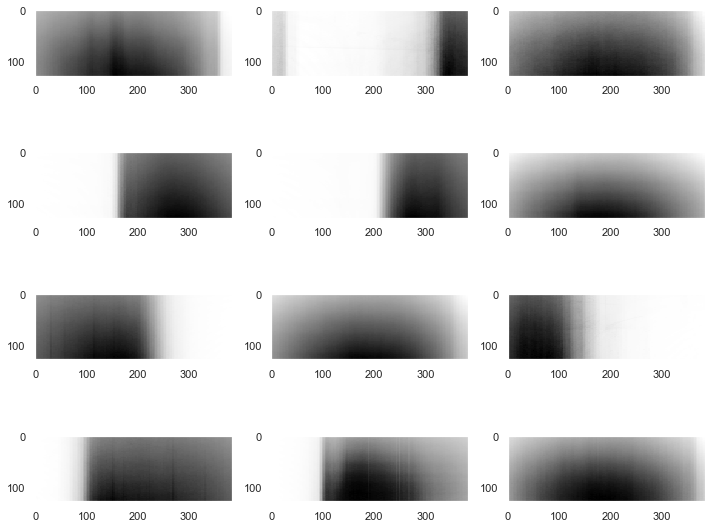

In [31]:
plot_cluster_centers(n_clusters, kmeans)

In [33]:
def get_tsne_projection(data):
    tsne = TSNE(n_components=2, init='random', random_state=0)
    projection = tsne.fit_transform(data)
    return projection

In [34]:
steel_projection = get_tsne_projection(flattened_images_X)

/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [35]:
def get_colors(num_classes):
    color_spectrum = ["lightcoral","steelblue","mediumseagreen","khaki"]
    
    if num_classes <= len(color_spectrum):
        colors = color_spectrum[:num_classes]
        return colors
    else:
        print(f'`num_classes` is greater than {len(color_spectrum)}')

- [Matplotlib Colors](https://matplotlib.org/stable/gallery/color/named_colors.html)
- [Matplotlib Legends](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html)

In [36]:
import matplotlib.colors as mc

def plot_tsne(projection, df):
    plt.figure(figsize=(10,10))
    num_classes = df.ClassId.nunique()
    colors = get_colors(num_classes)

    # Create a custom color map to represent our 4 different classes
    cmap = mc.LinearSegmentedColormap.from_list("", colors)

    scatter = plt.scatter(projection[:, 0], projection[:, 1], c=df.ClassId, cmap=cmap)
    plt.legend(*scatter.legend_elements(),loc='upper left');


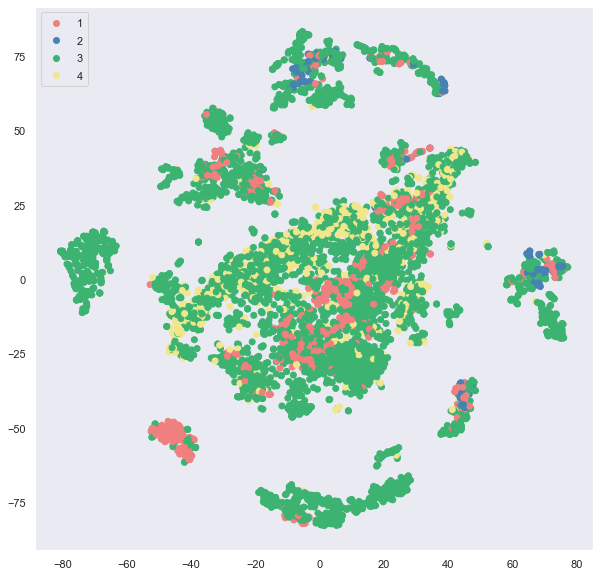

In [37]:
plot_tsne(steel_projection, df_flat_complete)

`t-SNE` does not seem to be able to split pictures well into clusters for our 4 `ClassIds`

#### without `ClassId` 3

In [38]:
class_3 = df_flat_complete.query('ClassId != 3')
class_3_x = class_3.drop(['ImageId','ClassId'], axis=1)

In [39]:
cl3_projection = get_tsne_projection(class_3_x)

/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


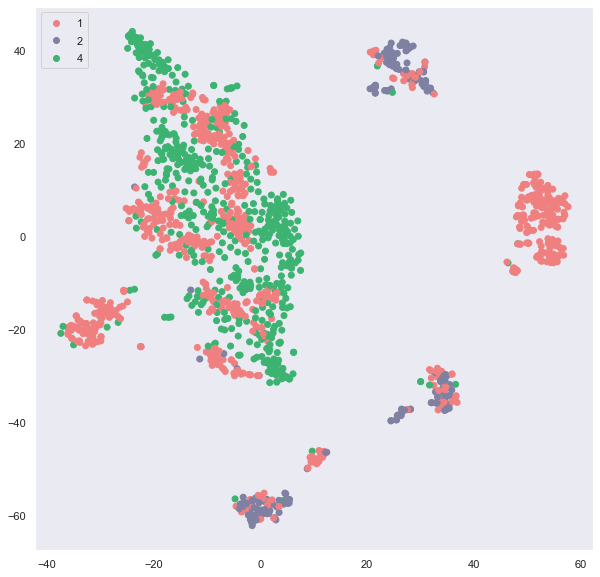

In [40]:
plot_tsne(cl3_projection, class_3)

---

#### Clustering with augmented pictures

In [42]:
df_aug = pd.read_csv('data/train_single_defects_augmented.csv')
df_aug.head(3)

,FilePath,ImageId,ClassId
0,/Users/fabioteichmann/neuefische/projects/Caps...,aug_1_873fbc272.jpg,1
1,/Users/fabioteichmann/neuefische/projects/Caps...,aug_2_525d0e51e.jpg,1
2,/Users/fabioteichmann/neuefische/projects/Caps...,aug_3_4c47ebc03.jpg,1


In [43]:
image_size=128

image = io.imread('data/augmentations/'+df_aug.ImageId[0])

image_resized=cv2.resize(image, (image_size,image_size))
#The input data have to be converted from 3 dimensional format to 1 dimensional format
image_flat = image_resized.reshape(1, 3 * image_size * image_size)
# Data Normalization
# Conversion to float
image_flat=image_flat.astype('float32')
# Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
image_flat = image_flat / 255.0

FileNotFoundError: No such file: '/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/data/augmentations/aug_1_873fbc272.jpg'

In [ ]:
plt.imshow(image_resized);

In [ ]:
# image_ids = df_aug.ImageId.to_list()
IMG_SIZE = 128

"""TO-DO, run time too long"""
# temp = get_prepared_images(df_aug, IMG_SIZE)

In [ ]:
# len(temp)

In [ ]:
# temp

In [ ]:
# temp2 = pd.DataFrame(temp , columns = ['ImageId', 'flattened_images'])
# temp2 = pd.merge(temp, df_aug[['ImageId','ClassId']], on='ImageId')


# temp2.head(2)

In [ ]:
temp

---

In [ ]:
digits_projrs= pd.DataFrame(clusters,columns = ['ClassId_pred'])

In [ ]:
clusters

In [ ]:
df

In [ ]:
df.reset_index(drop=True, inplace=True)
clusters.reset_index(drop=True, inplace=True)
result = pd.concat([df, clusters], axis=1)
result['ClassId_pred'] = result['ClassId_pred'].map({0: 1, 1: 2,2:3, 3:4})
#switch labels due to results from confusion matrix
#result['ClassId_pred'] = result['ClassId_pred'].map({1: 1, 2: 2, 3:4, 4:3})
result

In [ ]:
result.groupby('ClassId').count()

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(result['ClassId'],result['ClassId_pred']))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(result['ClassId'],result['ClassId_pred']), annot=True, cmap='YlGn');

769
195
4759
516


In [ ]:
print(metrics.classification_report(result['ClassId'],result['ClassId_pred']))

 ####  without TSNE and img_size = 128
   
           precision    recall  f1-score   support

           1       0.06      0.16      0.09       769
           2       0.04      0.18      0.06       195
           3       0.71      0.39      0.51      4759
           4       0.07      0.11      0.09       516

    accuracy                           0.34      6239
   macro avg       0.22      0.21      0.19      6239
weighted avg       0.56      0.34      0.41      6239

 #### with TSNE  and img_size = 128  
            precision    recall  f1-score   support

           1       0.18      0.40      0.25       769
           2       0.09      0.38      0.14       195
           3       0.68      0.28      0.40      4759
           4       0.11      0.37      0.17       516

    accuracy                           0.31      6239
   macro avg       0.26      0.36      0.24      6239
weighted avg       0.55      0.31      0.35      6239

## Clustering with HOG Features

In [76]:
# Loading the HOG feature dataset 
hog = pd.read_csv('data/train_HOG.csv')
hog.head()

,0,1,2,3,4,5,6,7,8,9,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,ImageId
0,0.260472,0.168138,0.260472,0.124914,0.117598,0.000000,0.023278,0.078617,0.071638,0.125196,...,0.234058,0.048746,0.040422,0.015478,0.129134,0.126747,0.194180,0.159938,0.224502,58ee62fd7.jpg
1,0.178531,0.146213,0.230136,0.135276,0.239207,0.089580,0.097348,0.154742,0.089257,0.239207,...,0.231136,0.044045,0.074165,0.047504,0.084607,0.057752,0.091826,0.118711,0.147404,eeffa4c49.jpg
2,0.233020,0.233020,0.233020,0.221273,0.198087,0.087594,0.057336,0.024053,0.085179,0.192792,...,0.152660,0.048371,0.032045,0.092339,0.158407,0.255698,0.255698,0.255698,0.049551,0dced41aa.jpg
3,0.199433,0.128030,0.110016,0.008214,0.155047,0.088910,0.155657,0.077873,0.260184,0.260184,...,0.221356,0.080780,0.033171,0.142762,0.186500,0.197350,0.193555,0.223840,0.068564,bd2366c49.jpg
4,0.357059,0.189545,0.000000,0.004834,0.050835,0.033951,0.123951,0.057806,0.084447,0.357059,...,0.361479,0.050235,0.024185,0.011188,0.037392,0.007501,0.008185,0.022333,0.227738,e2bdd4236.jpg


In [77]:
hog.shape

(12568, 3781)

In [78]:
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(hog)

In [79]:
hog.shape

(12141, 3781)

In [80]:
# Loading the complete dataset (including class 0)
df2 = pd.read_csv('data/train_complete.csv')
df2.head()

,FilePath,ImageId,ClassId,EncodedPixels,Defect
0,/Users/fabioteichmann/neuefische/projects/Caps...,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,/Users/fabioteichmann/neuefische/projects/Caps...,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,/Users/fabioteichmann/neuefische/projects/Caps...,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,/Users/fabioteichmann/neuefische/projects/Caps...,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,/Users/fabioteichmann/neuefische/projects/Caps...,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1


In [81]:
hog = hog.merge(df2, on='ImageId')
hog.head()

,0,1,2,3,4,5,6,7,8,9,...,3775,3776,3777,3778,3779,ImageId,FilePath,ClassId,EncodedPixels,Defect
0,0.260472,0.168138,0.260472,0.124914,0.117598,0.000000,0.023278,0.078617,0.071638,0.125196,...,0.129134,0.126747,0.194180,0.159938,0.224502,58ee62fd7.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,3,305622 43 305793 128 305964 4053 310018 255 31...,1
1,0.233020,0.233020,0.233020,0.221273,0.198087,0.087594,0.057336,0.024053,0.085179,0.192792,...,0.158407,0.255698,0.255698,0.255698,0.049551,0dced41aa.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,0,0,0
2,0.199433,0.128030,0.110016,0.008214,0.155047,0.088910,0.155657,0.077873,0.260184,0.260184,...,0.186500,0.197350,0.193555,0.223840,0.068564,bd2366c49.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,0,0,0
3,0.357059,0.189545,0.000000,0.004834,0.050835,0.033951,0.123951,0.057806,0.084447,0.357059,...,0.037392,0.007501,0.008185,0.022333,0.227738,e2bdd4236.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,3,17490 175 17746 175 18002 175 18258 175 18514 ...,1
4,0.148689,0.130765,0.193046,0.264011,0.266173,0.134977,0.046870,0.030897,0.026977,0.115430,...,0.225130,0.222193,0.224301,0.075570,0.216802,5210ac609.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,3,109810 15 110038 43 110266 71 110493 100 11072...,1


In [82]:
# eliminate class 0 images in dataset
hog = hog.query('ClassId!=0')
hog.shape

(6239, 3785)

In [83]:
hog_X=hog.drop(['ImageId','FilePath','ClassId','EncodedPixels','Defect'], axis = 1)

In [84]:
'''# Use TSNE before modeling
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(hog_X)
# Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(digits_proj)
kmeans.cluster_centers_.shape'''

"# Use TSNE before modeling\ntsne = TSNE(n_components=2, init='random', random_state=0)\ndigits_proj = tsne.fit_transform(hog_X)\n# Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)\nkmeans = KMeans(n_clusters=4, random_state=0)\nclusters = kmeans.fit_predict(digits_proj)\nkmeans.cluster_centers_.shape"

In [85]:
#without TSNE
#Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(hog_X)
kmeans.cluster_centers_.shape

(4, 3780)

In [86]:
clusters= pd.DataFrame(clusters,columns = ['ClassId_pred'])
clusters.head()

,ClassId_pred
0,3
1,0
2,3
3,3
4,1


In [87]:
hog.reset_index(drop=True, inplace=True)
clusters.reset_index(drop=True, inplace=True)
result = pd.concat([hog, clusters], axis=1)
result['ClassId_pred'] = result['ClassId_pred'].map({0: 1, 1: 2,2:3, 3:4})
#switch labels due to results from confusion matrix
#result['ClassId_pred'] = result['ClassId_pred'].map({1: 1, 2: 2, 3:4, 4:3})
result.head()

,0,1,2,3,4,5,6,7,8,9,...,3776,3777,3778,3779,ImageId,FilePath,ClassId,EncodedPixels,Defect,ClassId_pred
0,0.260472,0.168138,0.260472,0.124914,0.117598,0.000000,0.023278,0.078617,0.071638,0.125196,...,0.126747,0.194180,0.159938,0.224502,58ee62fd7.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,3,305622 43 305793 128 305964 4053 310018 255 31...,1,4
1,0.357059,0.189545,0.000000,0.004834,0.050835,0.033951,0.123951,0.057806,0.084447,0.357059,...,0.007501,0.008185,0.022333,0.227738,e2bdd4236.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,3,17490 175 17746 175 18002 175 18258 175 18514 ...,1,1
2,0.148689,0.130765,0.193046,0.264011,0.266173,0.134977,0.046870,0.030897,0.026977,0.115430,...,0.222193,0.224301,0.075570,0.216802,5210ac609.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,3,109810 15 110038 43 110266 71 110493 100 11072...,1,4
3,0.232456,0.182727,0.232456,0.114182,0.081682,0.061414,0.078733,0.074309,0.046661,0.213257,...,0.000000,0.089722,0.005452,0.170246,48831ab9e.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,3,182511 1 182765 3 183020 3 183275 4 183530 4 1...,1,4
4,0.245800,0.245800,0.245800,0.061941,0.198235,0.081538,0.053705,0.154272,0.110223,0.245800,...,0.064323,0.088688,0.064323,0.237683,d5cf4a417.jpg,/Users/fabioteichmann/neuefische/projects/Caps...,3,93762 11 94017 22 94272 23 94527 24 94782 26 9...,1,2


[[ 142  363  182   82]
 [   7  137   51    0]
 [ 999 1730  733 1297]
 [  29  251    6  230]]


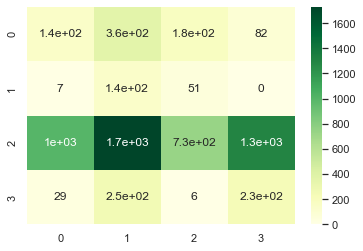

In [55]:
from sklearn import metrics
print(metrics.confusion_matrix(result['ClassId'],result['ClassId_pred']))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(result['ClassId'],result['ClassId_pred']), annot=True, cmap='YlGn');

In [56]:
print(metrics.classification_report(result['ClassId'],result['ClassId_pred']))

              precision    recall  f1-score   support

           1       0.12      0.18      0.15       769
           2       0.06      0.70      0.10       195
           3       0.75      0.15      0.26      4759
           4       0.14      0.45      0.22       516

    accuracy                           0.20      6239
   macro avg       0.27      0.37      0.18      6239
weighted avg       0.60      0.20      0.23      6239



In [ ]:
'''# Create a labels array to match the learned cluster lables with the true labels
labels = np.zeros_like(clusters)
for i in range(4):
    mask = (clusters == i)
    labels[mask] = mode(hog.ClassId[mask])[0]'''

### HOG without TSNE        
        precision    recall  f1-score   support

           1       0.12      0.18      0.15       769
           2       0.06      0.70      0.10       195
           3       0.81      0.27      0.41      4759
           4       0.01      0.01      0.01       516

    accuracy                           0.25      6239
   macro avg       0.25      0.29      0.17      6239
weighted avg       0.63      0.25      0.33      6239

   ### HOG with TSNE        
        precision    recall  f1-score   support

           1       0.12      0.36      0.18       769
           2       0.00      0.04      0.01       195
           3       0.77      0.18      0.29      4759
           4       0.02      0.03      0.02       516

    accuracy                           0.18      6239
   macro avg       0.23      0.15      0.12      6239
weighted avg       0.61      0.18      0.24      6239

## Using HOG Image in Clustering

In [57]:
image = io.imread("data/train_images/000f6bf48.jpg")

In [58]:
from skimage.transform import resize
resized_img = resize(image, (64,128))

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

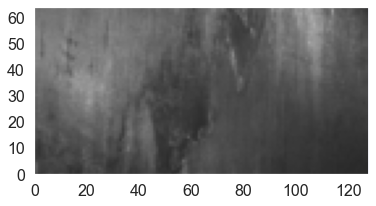

In [59]:
plt.imshow(resized_img)
plt.xlim(0,128)
plt.ylim(0,64)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [60]:
from skimage.feature import hog
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

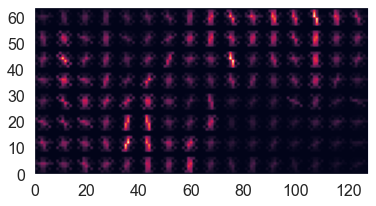

In [61]:
plt.imshow(hog_image)
plt.xlim(0,128)
plt.ylim(0,64)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [62]:
pic_n = hog_image.reshape(hog_image.shape[0]*hog_image.shape[1],1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
#clusters = kmeans.fit_predict(hog_image)
#kmeans.cluster_centers_.shape

In [63]:
pic2show = kmeans.cluster_centers_[kmeans.labels_]

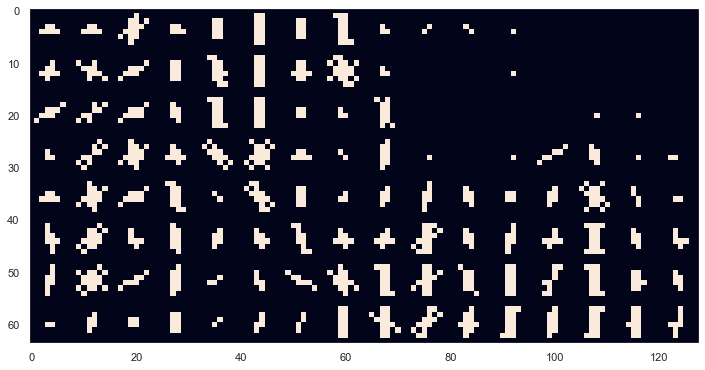

In [64]:
cluster_pic = pic2show.reshape(hog_image.shape[0], hog_image.shape[1])
plt.figure(figsize=(12,10))
plt.imshow(cluster_pic);

In [65]:
cluster_pic

array([[0.00149033, 0.00149033, 0.00149033, ..., 0.00149033, 0.00149033,
        0.00149033],
       [0.00149033, 0.00149033, 0.00149033, ..., 0.00149033, 0.00149033,
        0.00149033],
       [0.00149033, 0.00149033, 0.00149033, ..., 0.00149033, 0.00149033,
        0.00149033],
       ...,
       [0.00149033, 0.00149033, 0.00149033, ..., 0.00149033, 0.00149033,
        0.00149033],
       [0.00149033, 0.00149033, 0.00149033, ..., 0.00149033, 0.00149033,
        0.00149033],
       [0.00149033, 0.00149033, 0.00149033, ..., 0.00149033, 0.00149033,
        0.00149033]])

In [66]:
hog_image.shape

(64, 128)

In [67]:
kmeans.labels_.shape

(8192,)

In [68]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import mask_conversion

In [69]:
mask_pic = kmeans.labels_.reshape(hog_image.shape[0], hog_image.shape[1])

In [70]:
mask_pic.shape

(64, 128)

In [71]:
list(set(kmeans.labels_))

[0, 1]

In [72]:

DIMENSION = (64,128)
encoded_pixels = mask_conversion.encode_pixel(mask_pic, 3)
mask_conversion.decode_pixel(DIMENSION,encoded_pixels=encoded_pixels,class_id=1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

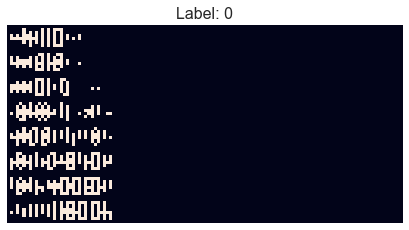

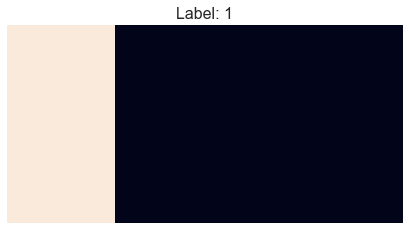

In [73]:
# get unique values in kmeans labels
labels = list(set(kmeans.labels_))

for label in labels:
    DIMENSION = mask_pic.shape
    encoded_pixels=mask_conversion.encode_pixel(mask_pic, label)
    
    mask = mask_conversion.decode_pixel(DIMENSION,encoded_pixels=encoded_pixels,class_id=1)

    plt.figure(figsize=(25, 8))
        
    ax = plt.subplot(len(labels), 1, label + 1)
    #plt.imshow(img)
    title = f'Label: {label}'
    
    plt.title(title, fontsize=16);
    plt.axis("off")

    plt.imshow(mask)